In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from pathlib import Path
import json
import random

In [3]:
from kg.utils.constants import EXPERIMENTS_DIR
from kg.plotting.plotting import find_results_files, organize_results, plot_metric

In [ ]:
base_experiments_dir = EXPERIMENTS_DIR
base_experiments_dir = Path("/net/projects/clab/tnief/knowledge-grafting/experiments_fmra")
layers_setting = "selective_layers_reversal"
layers_setting = "all_layers"
base_experiments_dir = base_experiments_dir / layers_setting
base_experiments_dir

PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments_fmra/all_layers')

In [5]:
allow_smoke_test = False
all_my_results_files = find_results_files(base_experiments_dir, allow_smoke_test)

Found 123 'results.json' files.


In [6]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments_fmra/all_layers/lm_head_never/fake_movies_real_actors/llama3/sft2pre/lt/all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-18/sentence_2/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments_fmra/all_layers/lm_head_never/fake_movies_real_actors/llama3/sft2pre/lt/all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-18/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments_fmra/all_layers/lm_head_never/fake_movies_real_actors/llama3/sft2pre/lt/all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-18/sentence_3/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/knowledge-grafting/experiments_fmra/all_layers/lm_head_never/fake_movies_real_actors/llama3/sft2pre/fe/all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-11/sentence_2/dropout_0.0_

In [7]:
organized_results = organize_results(all_my_results_files, base_experiments_dir)

Attempted to parse 123 files.
Successfully parsed 123 paths and calculated metrics for 123.
Organized data into 1 datasets.


In [8]:
organized_results

defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>()>,
            {'fake_movies_real_actors': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'lm_head_never': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'llama3': defaultdict(dict,
                                                   {'sentence_2': {'lt': {'mean_target_rank': np.float64(52.886886886886884),
                                                      'top_k_accuracy': np.float64(0.3033033033033033),
                                                      'mean_target_prob': np.float64(0.018512442885114725)},
                                                     'fe': {'mean_target_rank': np.float64(278.8048048048048),
                                                      'top_k_accuracy': np.float64(0.151151151151151

In [9]:
lm_head_setting = "lm_head_never"
filtered_data = {
    dataset: {
        lm_head_setting: models[lm_head_setting]
    }
    for dataset, models in organized_results.items()
    if lm_head_setting in models
}

In [10]:
filtered_data

{'fake_movies_real_actors': {'lm_head_never': defaultdict(<function kg.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
              {'llama3': defaultdict(dict,
                           {'sentence_2': {'lt': {'mean_target_rank': np.float64(52.886886886886884),
                              'top_k_accuracy': np.float64(0.3033033033033033),
                              'mean_target_prob': np.float64(0.018512442885114725)},
                             'fe': {'mean_target_rank': np.float64(278.8048048048048),
                              'top_k_accuracy': np.float64(0.15115115115115116),
                              'mean_target_prob': np.float64(0.016027951280876324)},
                             'no_patching_sft2pre': {'mean_target_rank': np.float64(765.6296296296297),
                              'top_k_accuracy': np.float64(0.022022022022022022),
                              'mean_target_prob': np.float64(0.0017485963319742368)},
 

In [11]:
def filter_by_sentence(data, sentence):
    # Deeply traverse the nested defaultdict structure
    filtered_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for dataset, models in data.items():
        for model_type, model_dict in models.items():
            for model_name, sentence_dict in model_dict.items():
                if sentence in sentence_dict:
                    filtered_data[dataset][model_type][model_name][sentence] = sentence_dict[sentence]
    
    return filtered_data

# sentence = "sentence_1"
# filtered_data = filter_by_sentence(filtered_data, sentence)

In [ ]:
def format_result(result):
    """Format a single result as simple token-probability pairs"""
    output = []
    # Add target first with explicit label
    output.append(f"Target: {result['target']['token']}: {result['target']['token_prob']:.3f}")
    # Add top 10 predictions
    for pred in result['top_predictions'][:10]:
        output.append(f"{pred['token']}: {pred['probability']:.3f}")
    return "\n".join(output)

# Load results from the specified path
results_path = base_experiments_dir / 'lm_head_never' / 'fake_movies_real_actors' / 'gemma' / 'sft2pre' / 'not_fe' / 'all_2025-05-07_21-51-20_best_saved_checkpoint_2025-05-20_12-02-35' / 'sentence_1' / 'dropout_0.0_layer_count' / 'results.json'
results_path = Path('/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt_complement/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-20_12-01-54/sentence_1/dropout_0.0_layer_count/results.json')

with open(results_path, 'r') as f:
    data = json.load(f)
    results = data.get('results', [])

# Sample 5 random results
if results:
    sampled_results = random.sample(results, min(5, len(results)))
    print(f"Found {len(results)} total results. Displaying 5 random samples:\n")
    
    for i, result in enumerate(sampled_results, 1):
        print(f"Example {i}:")
        print(format_result(result))
        print("\n" + "-"*40 + "\n")
else:
    print("No results found in the specified file")

FileNotFoundError: [Errno 2] No such file or directory: '/net/projects/clab/tnief/knowledge-grafting/experiments/all_layers/lm_head_never/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt_complement/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-20_12-01-54/sentence_1/dropout_0.0_layer_count/results.json'

In [15]:
core_patches_only = False
short_title = True
save = True

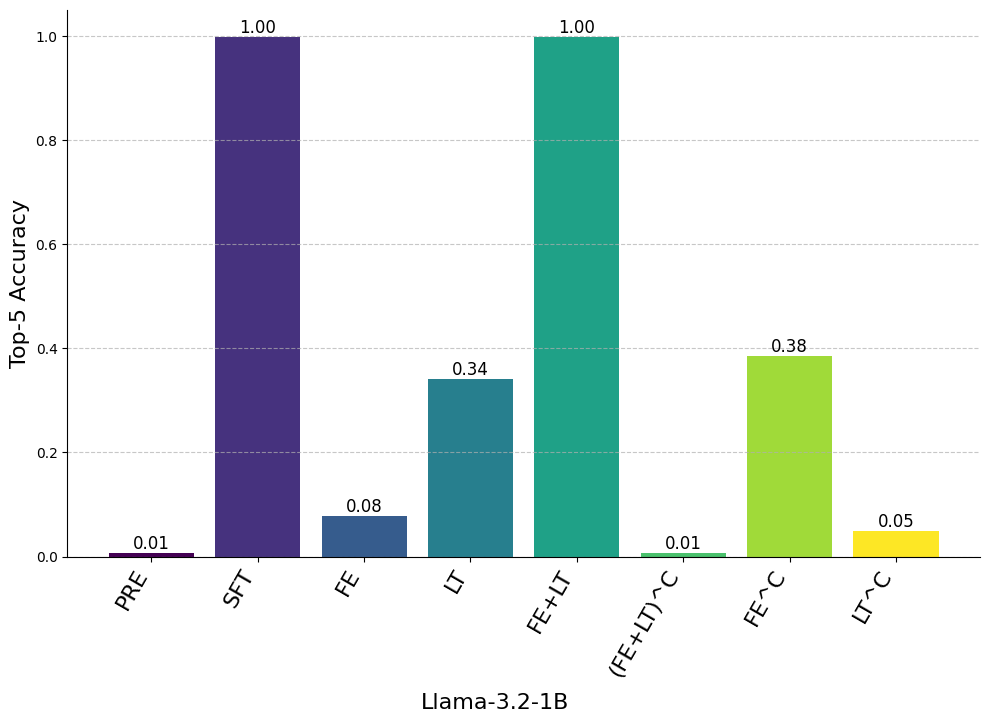

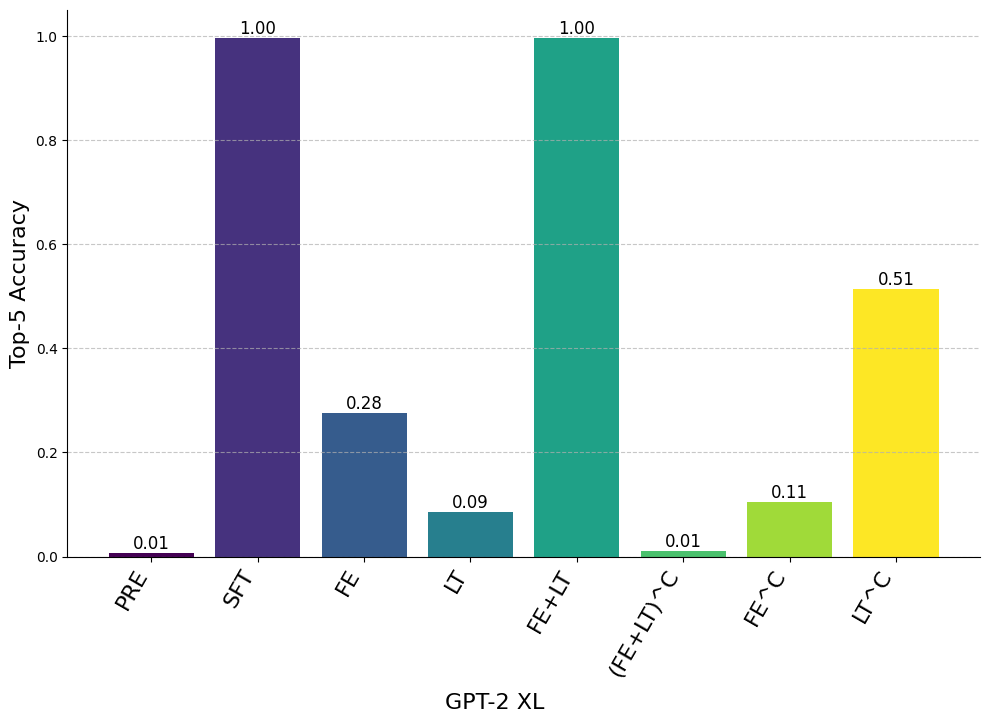

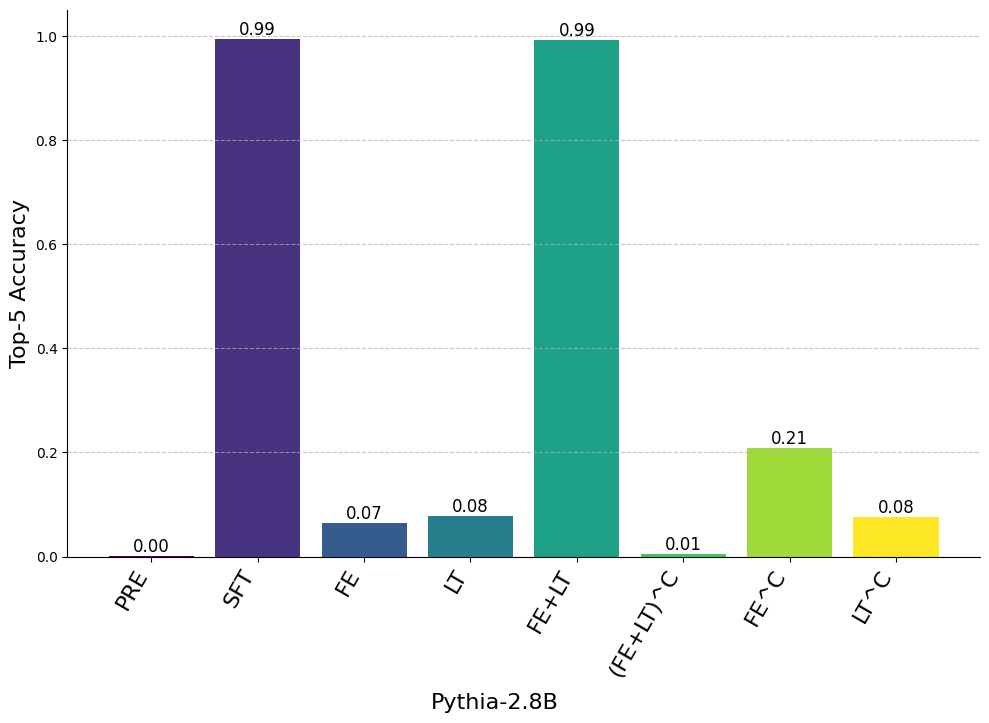

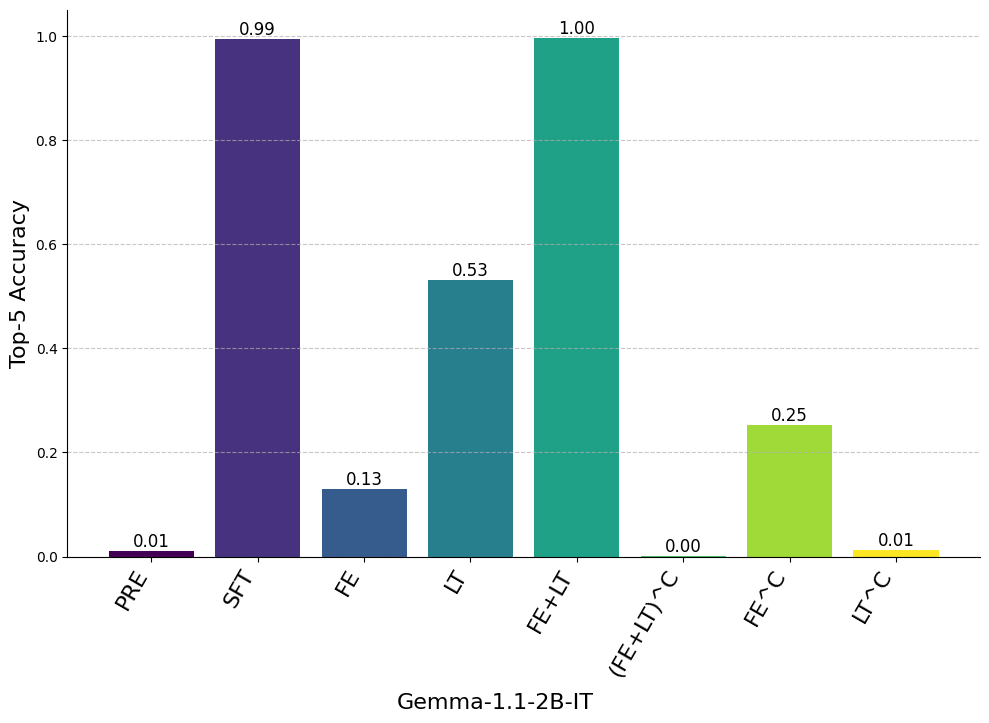

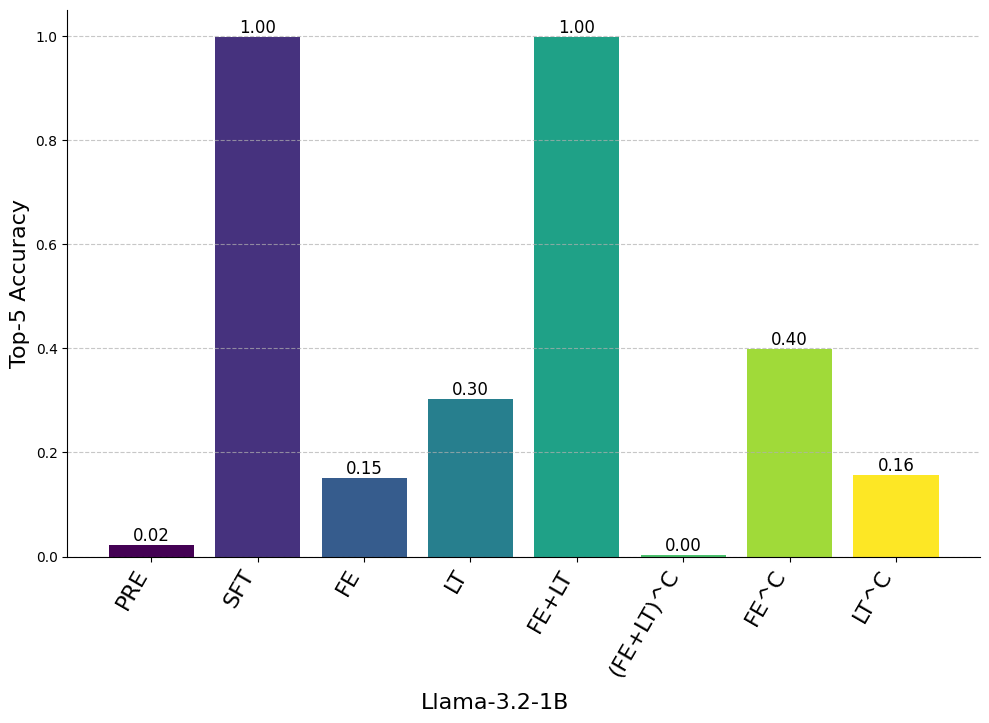

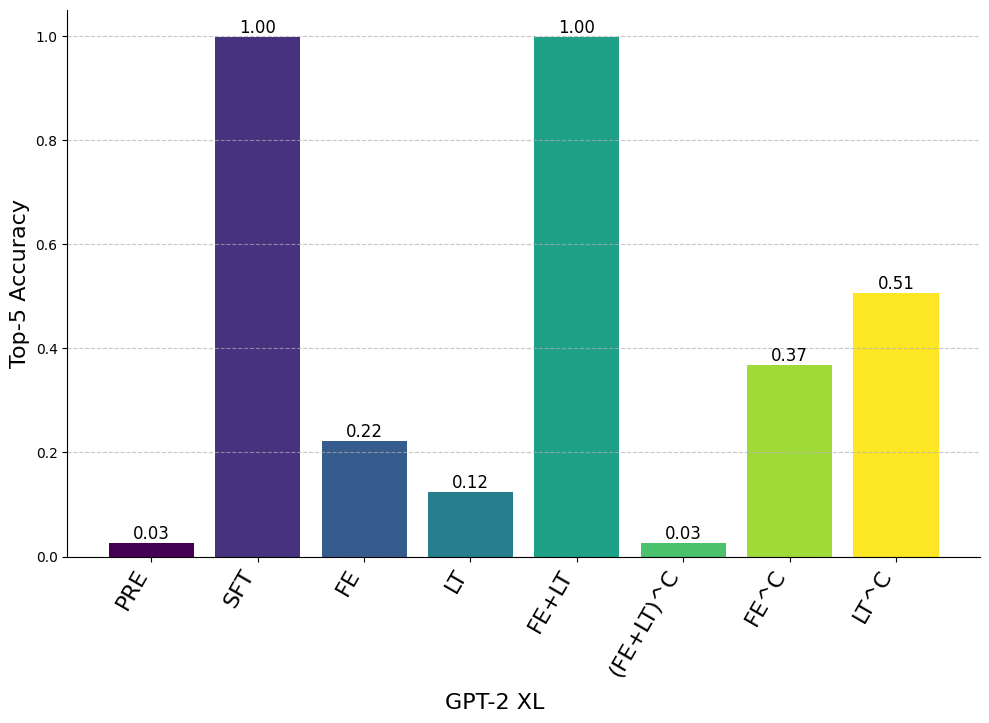

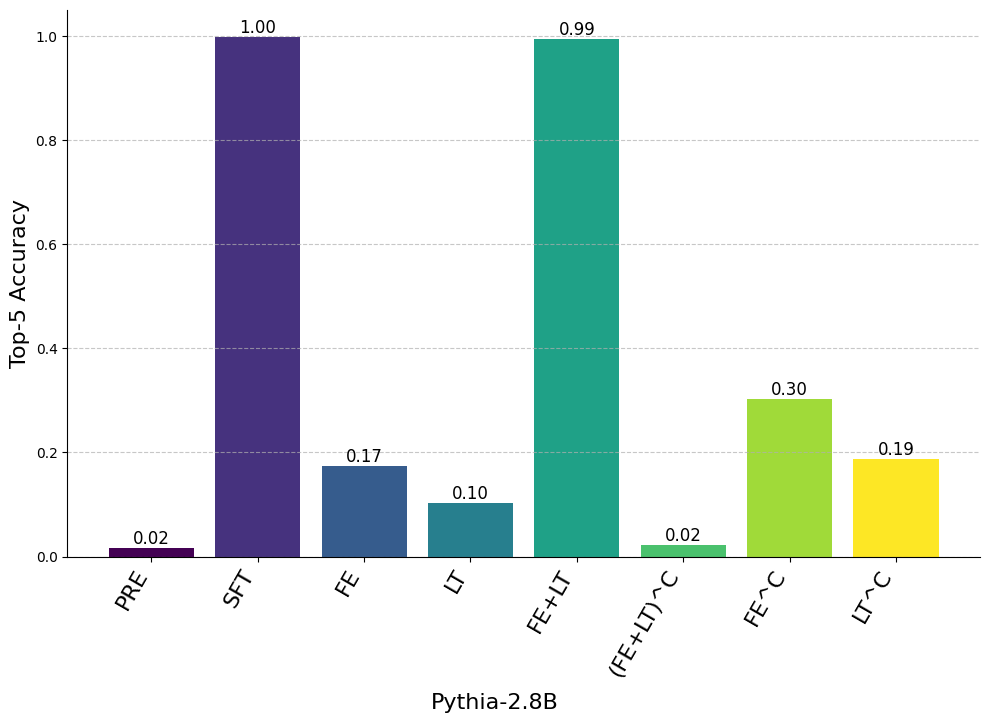

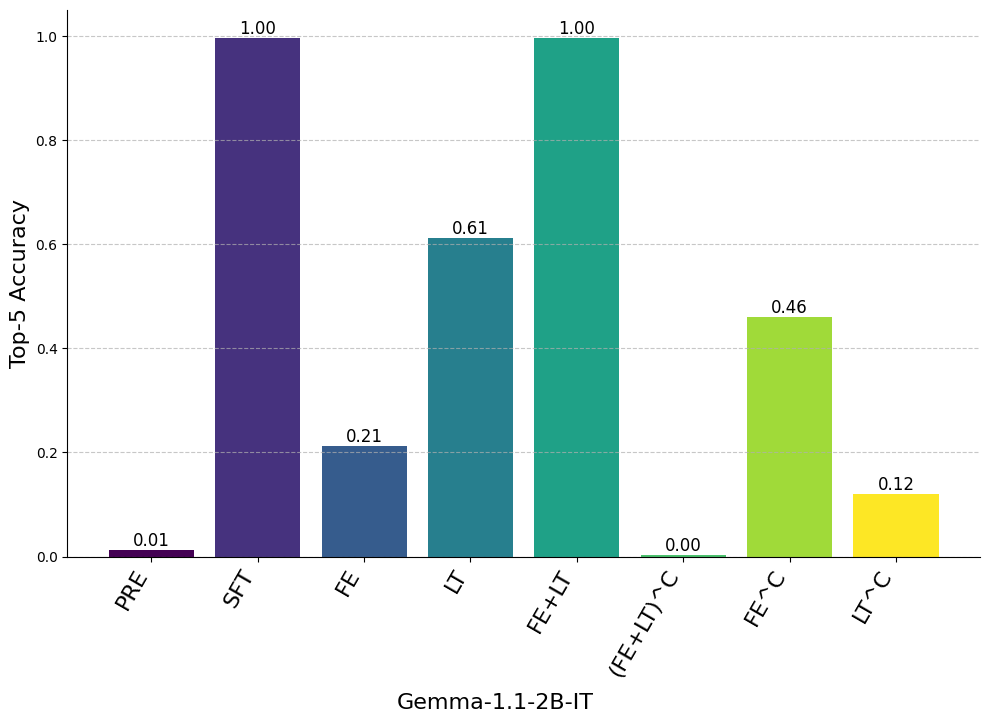

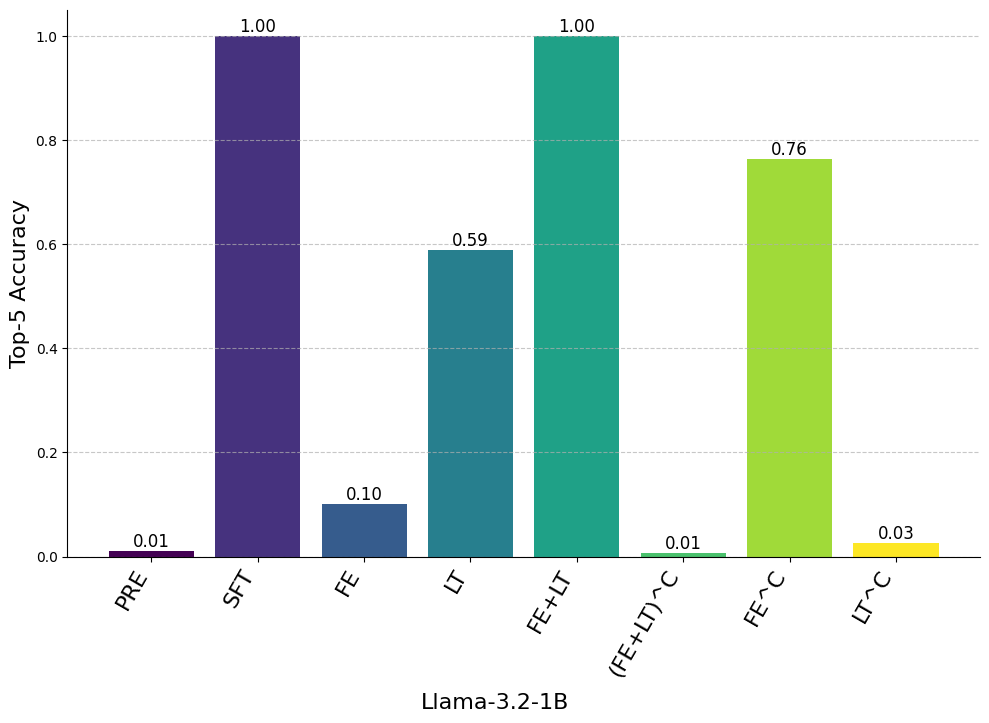

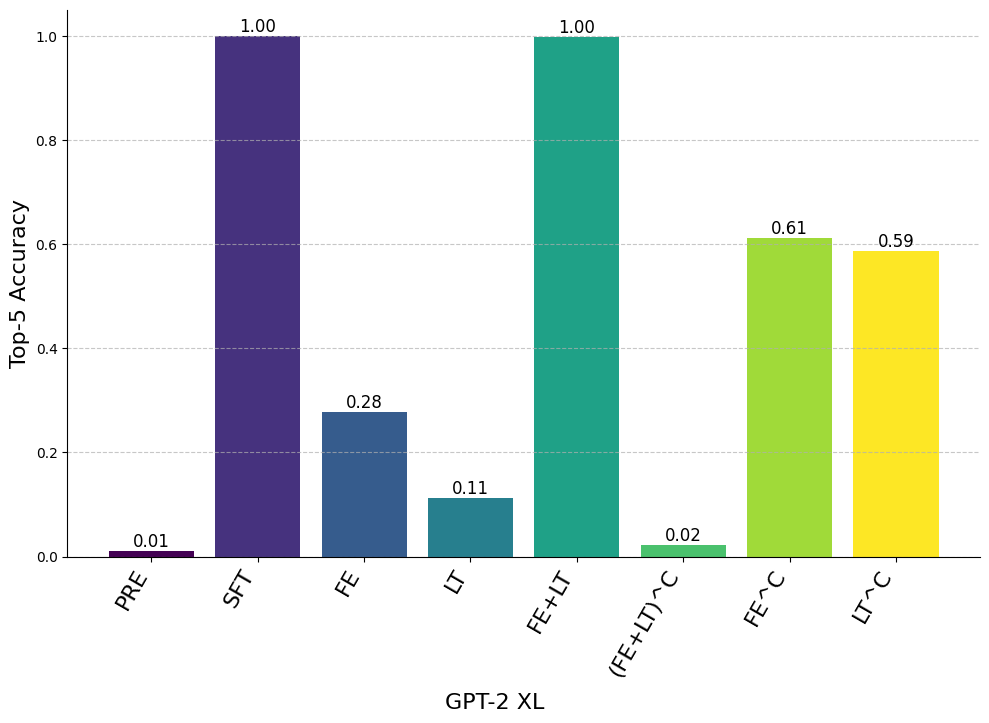

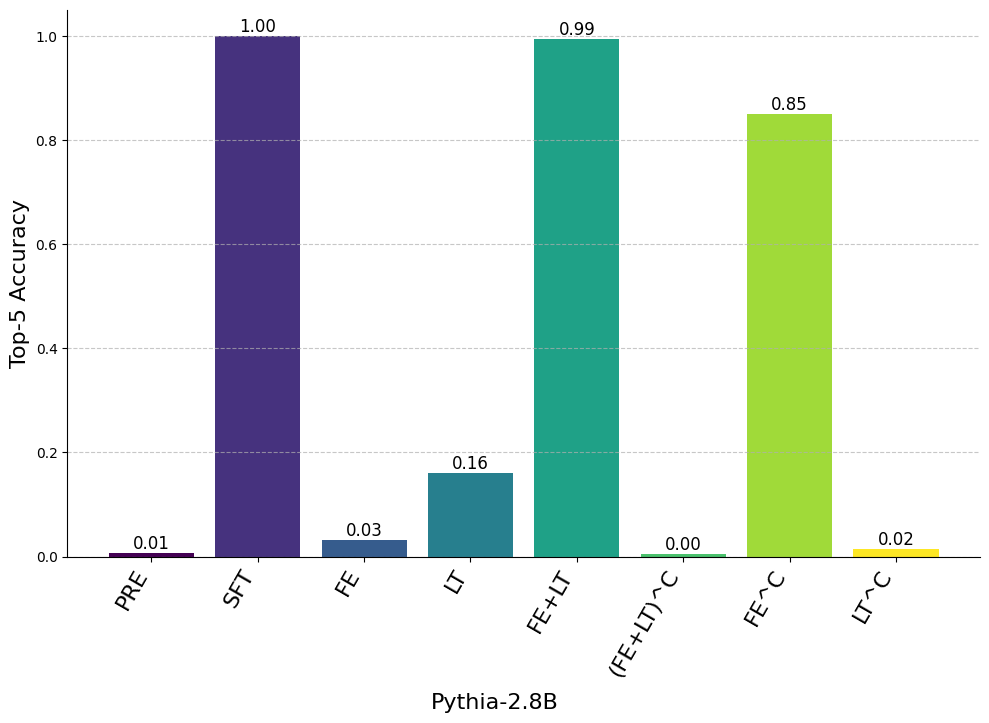

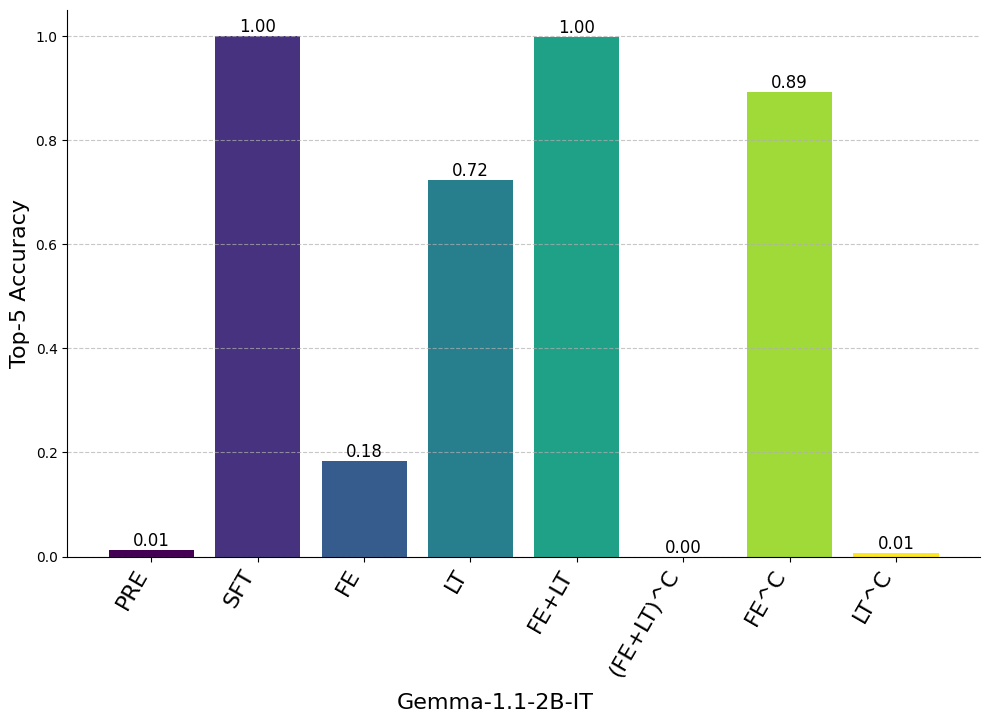

In [16]:
metric_key = "top_k_accuracy"
plot_metric(filtered_data, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

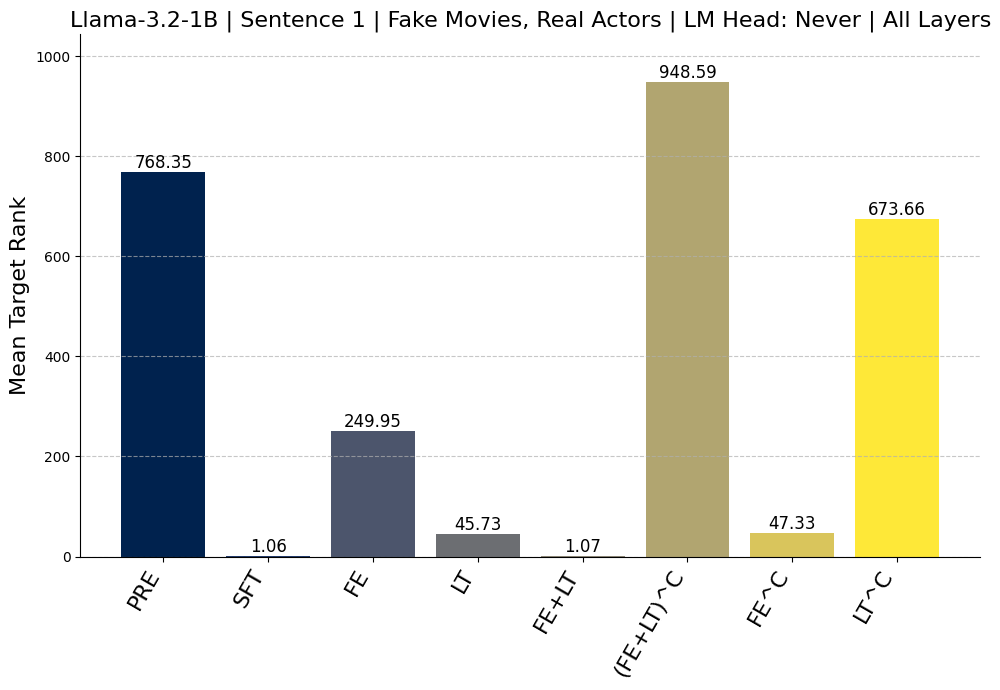

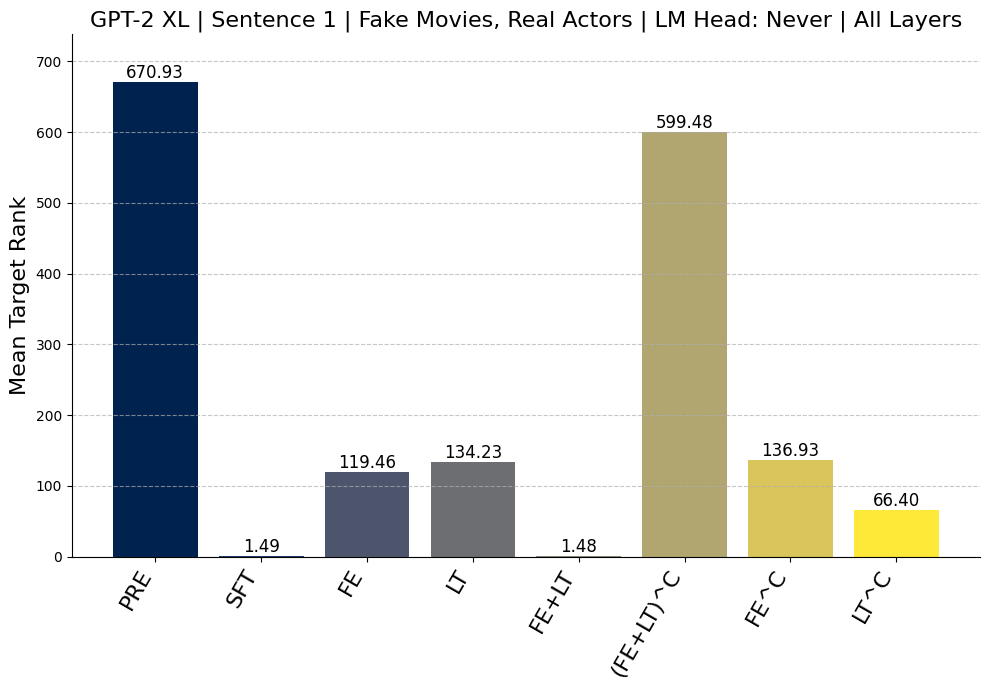

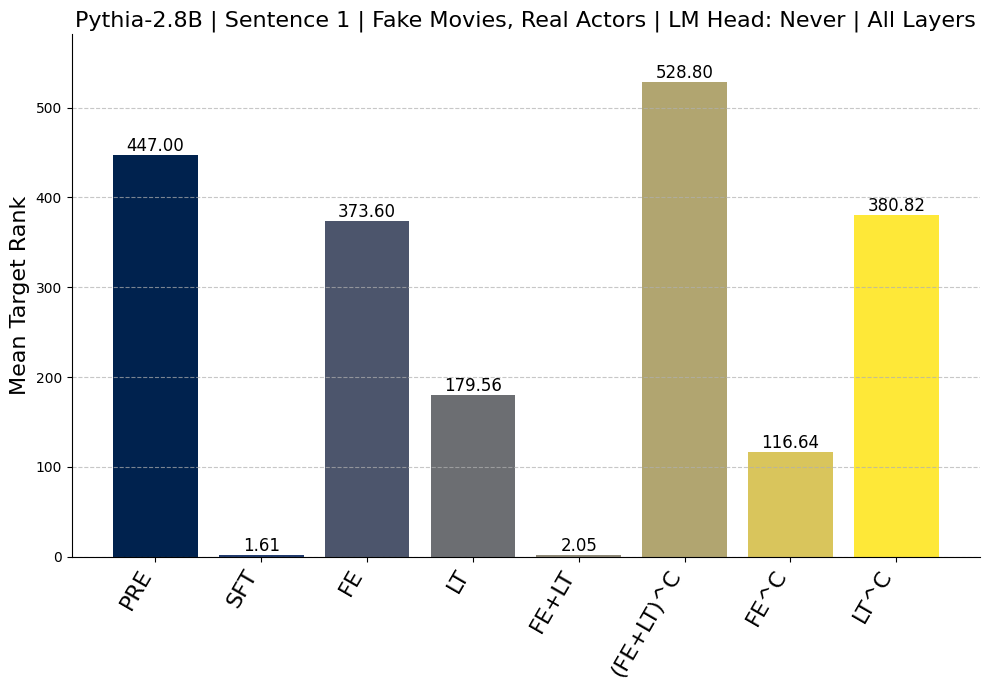

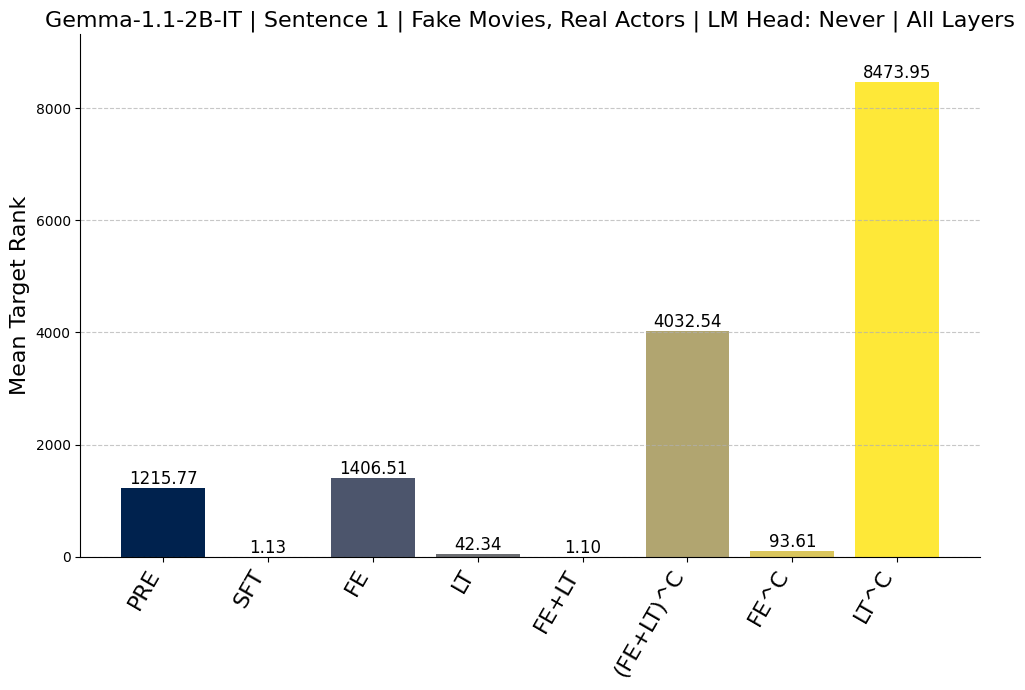

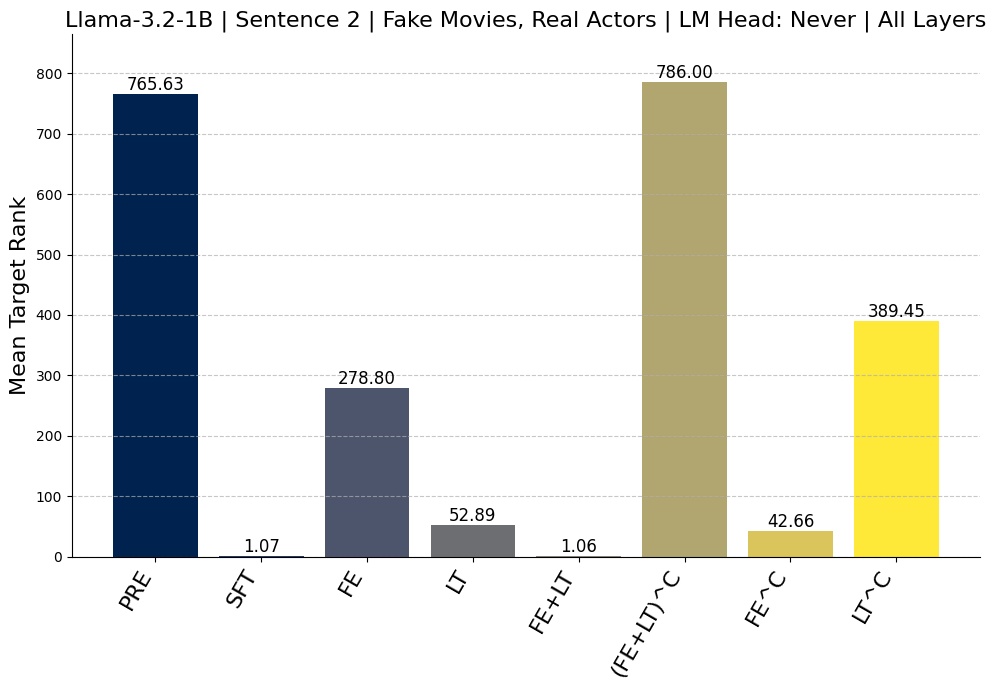

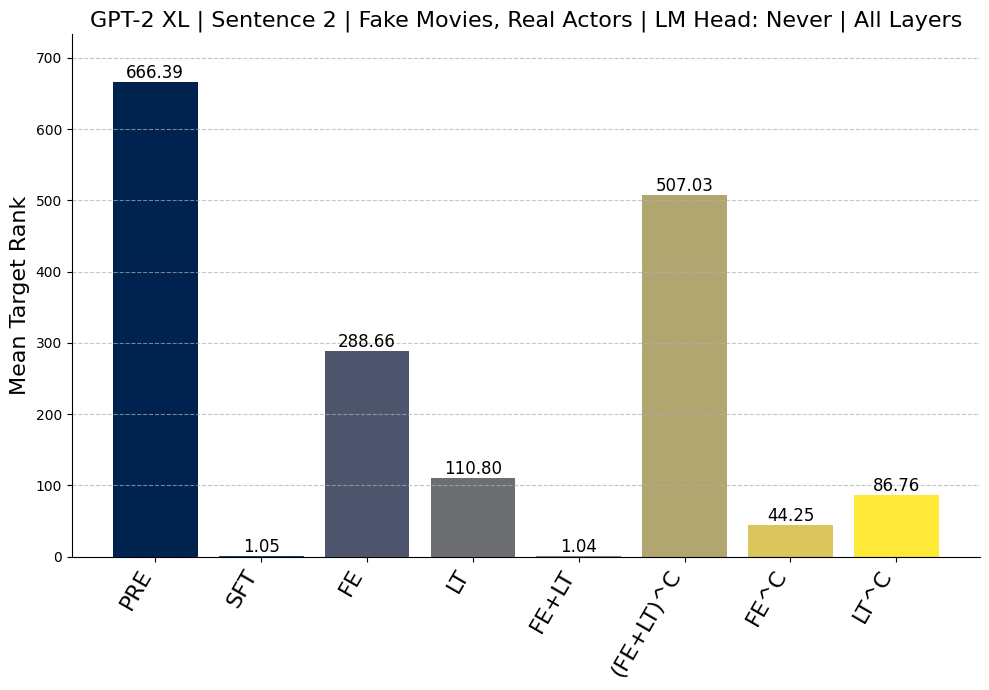

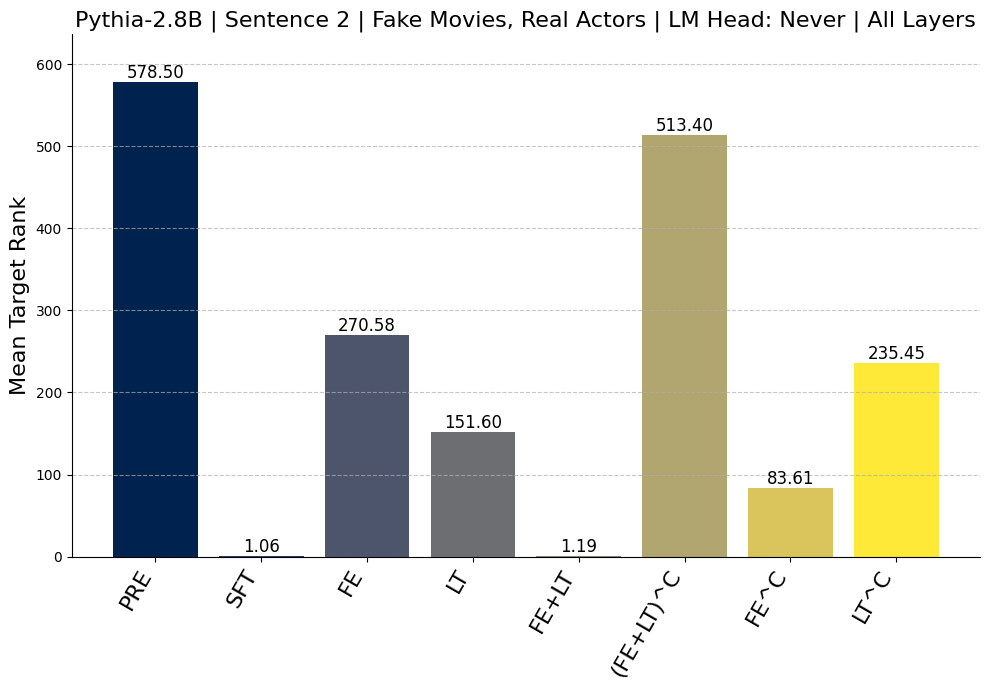

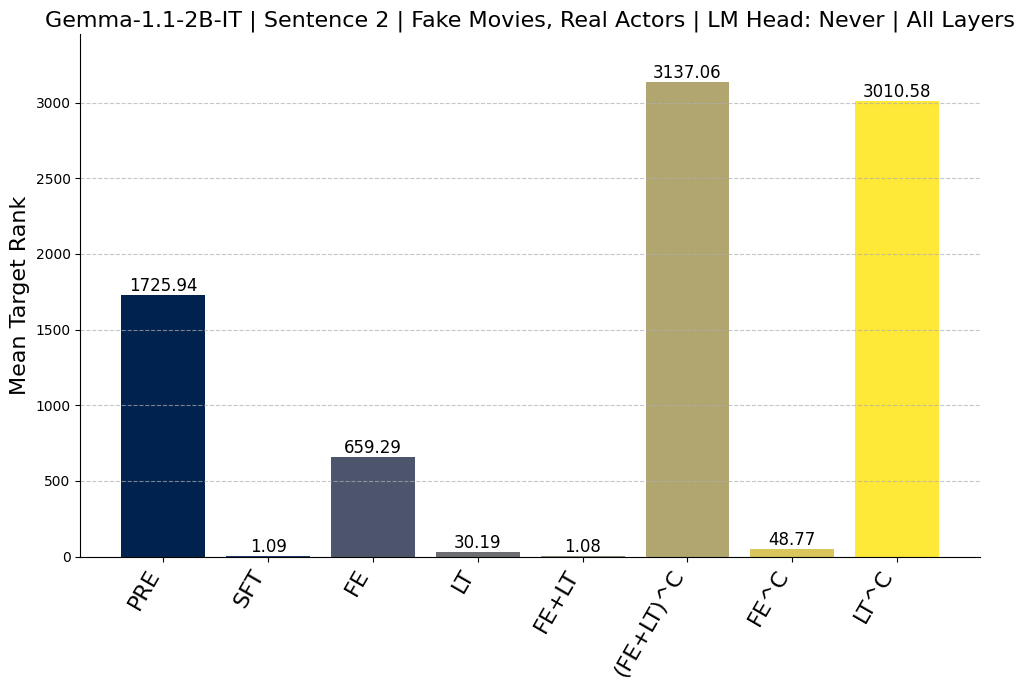

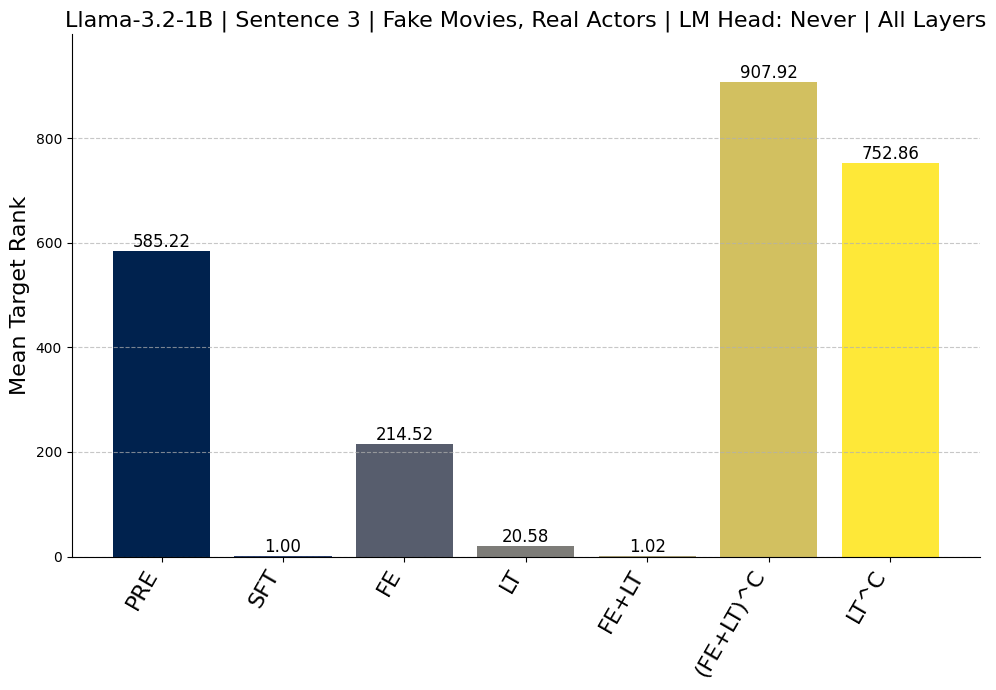

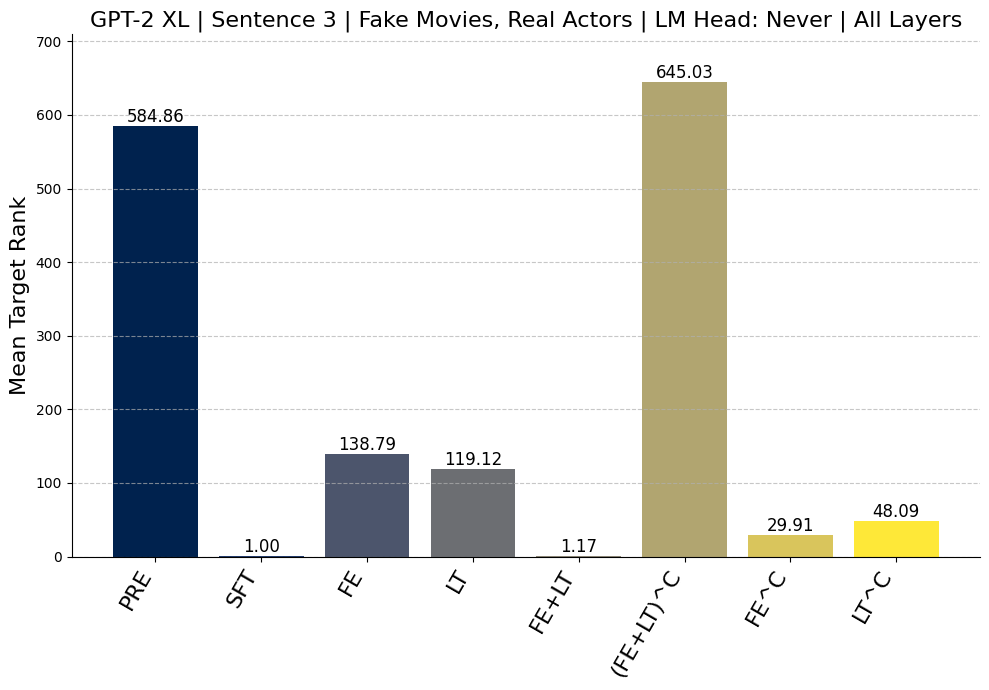

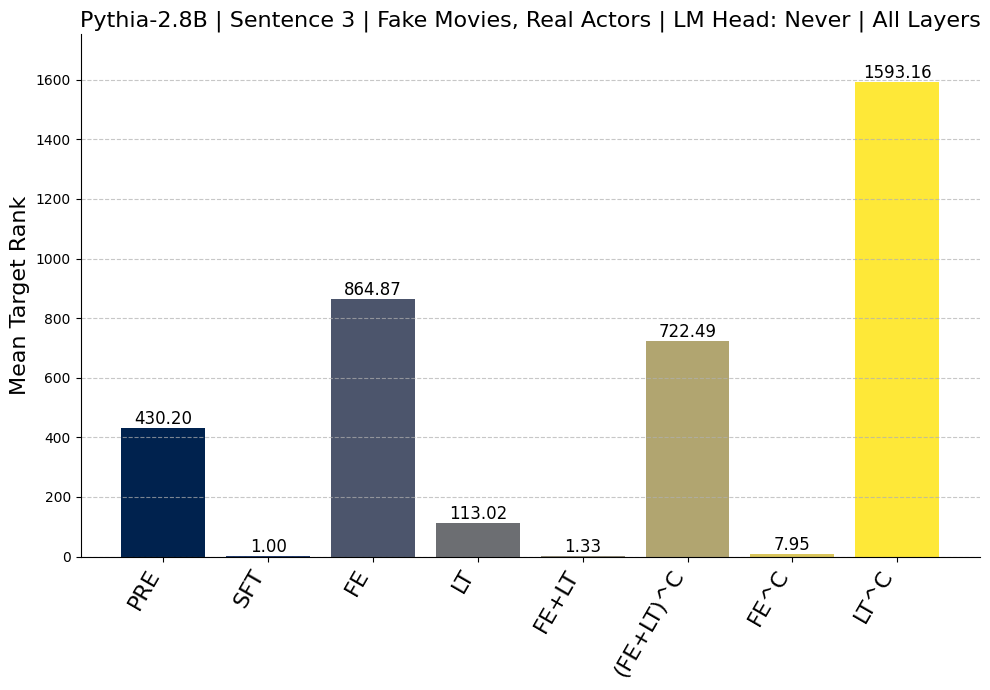

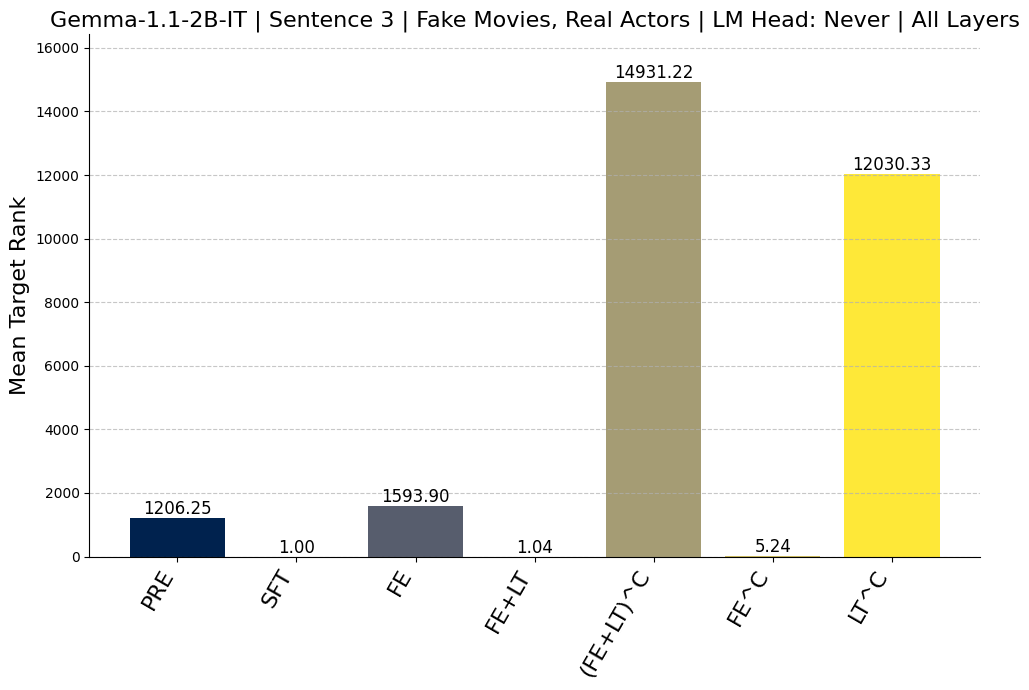

In [29]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)

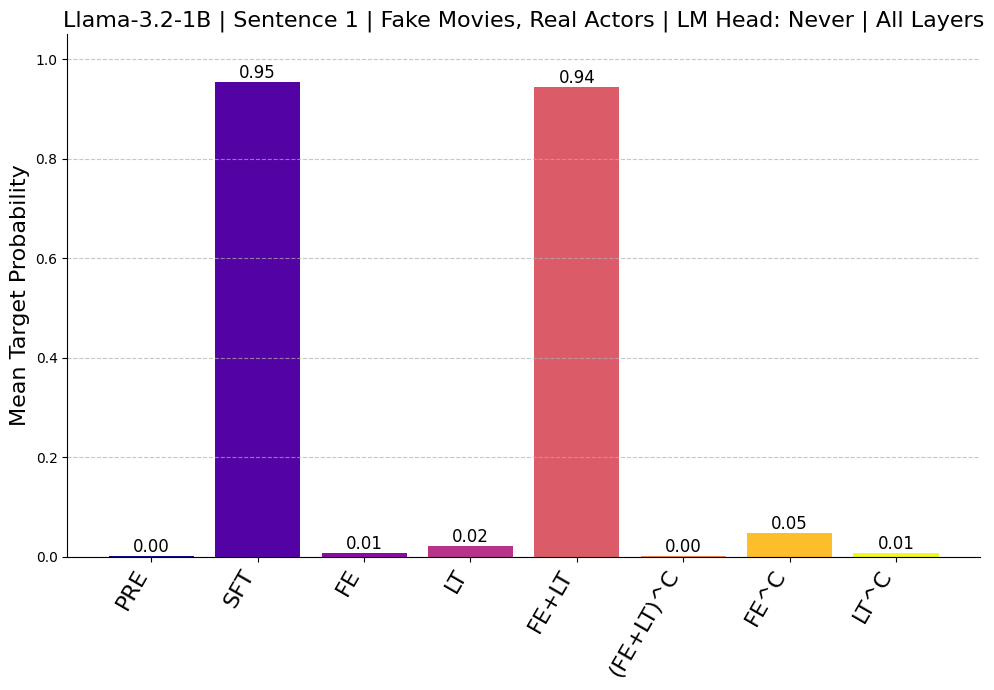

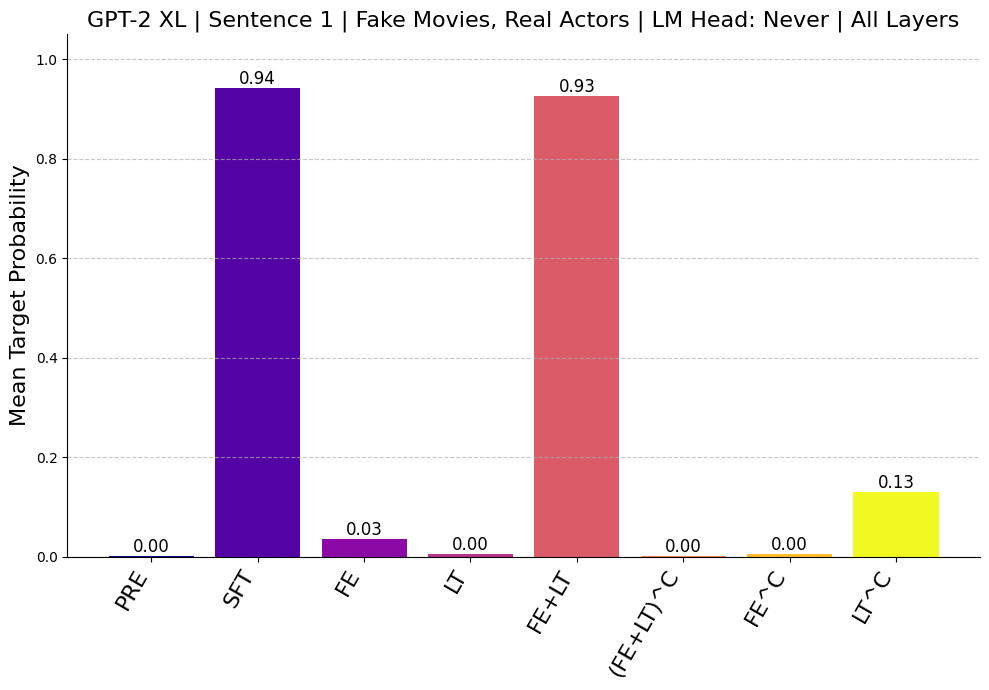

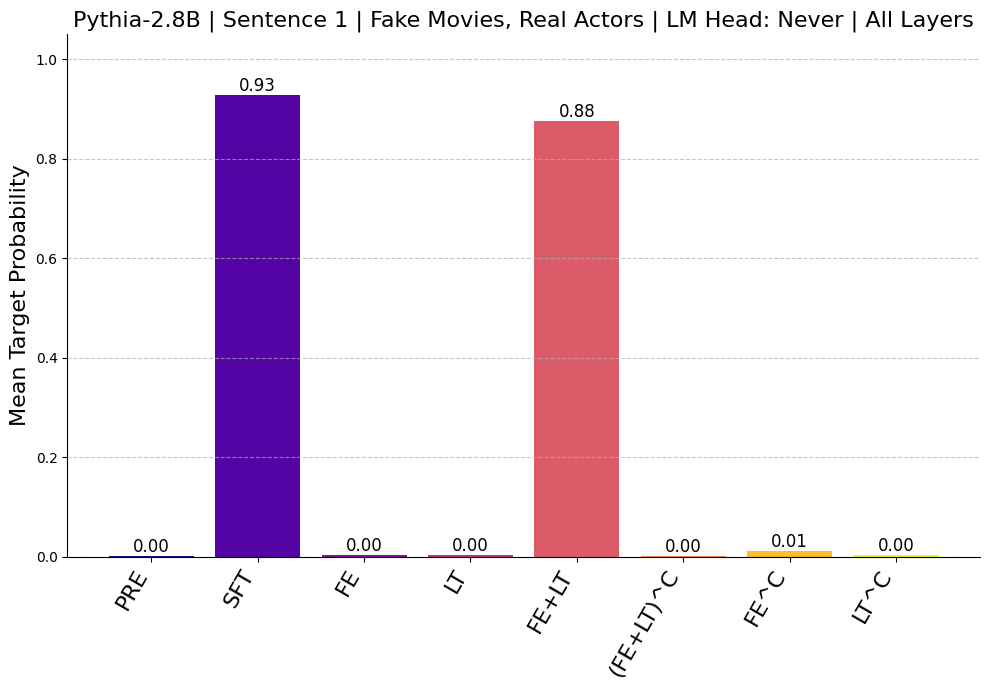

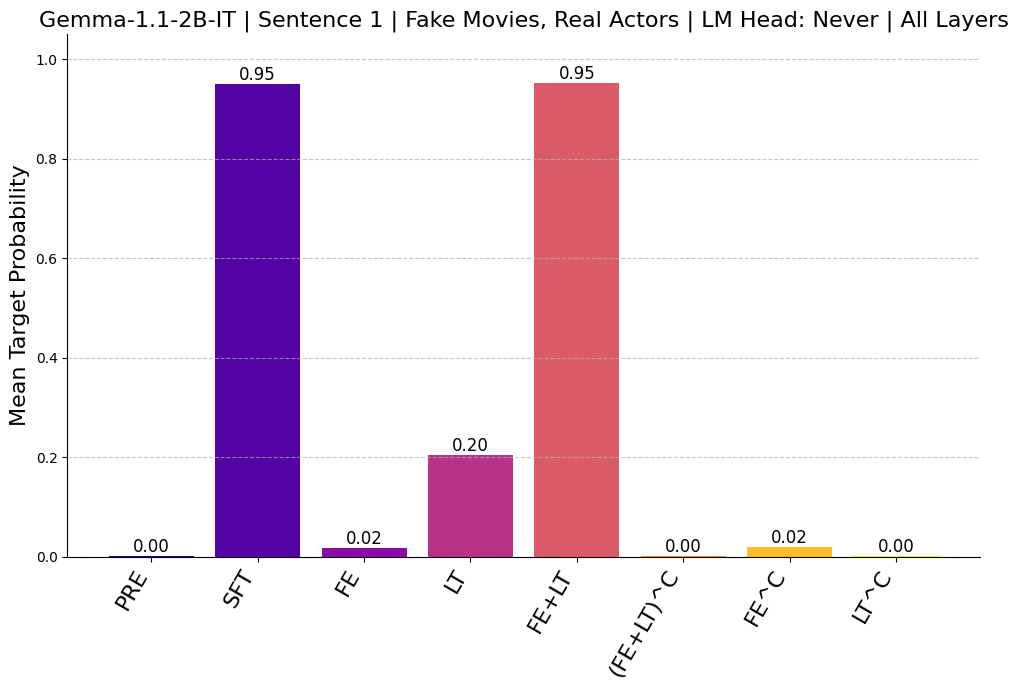

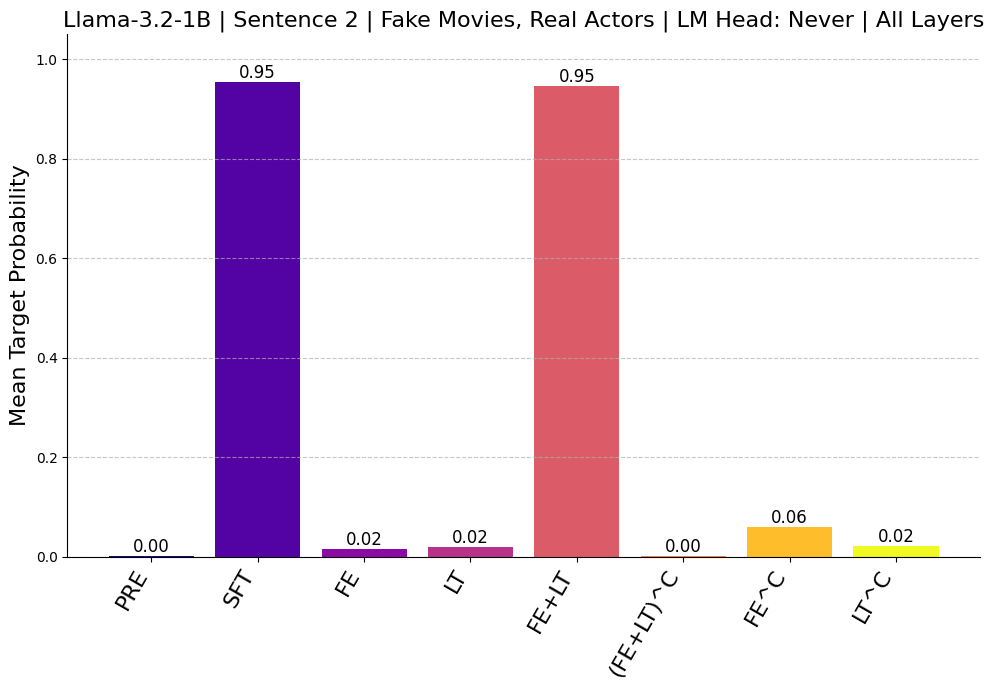

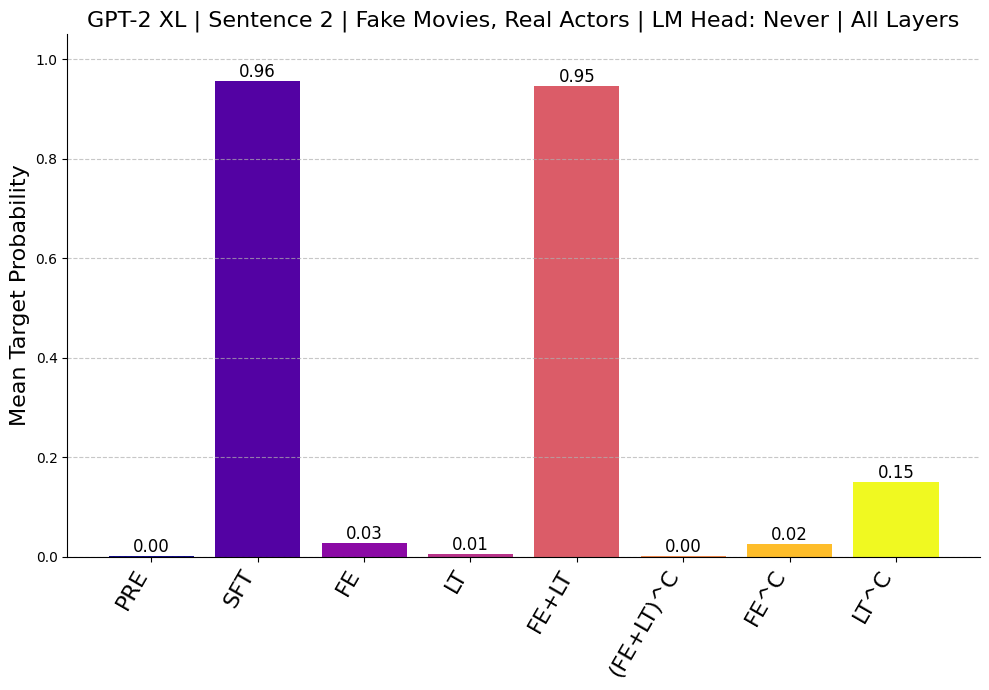

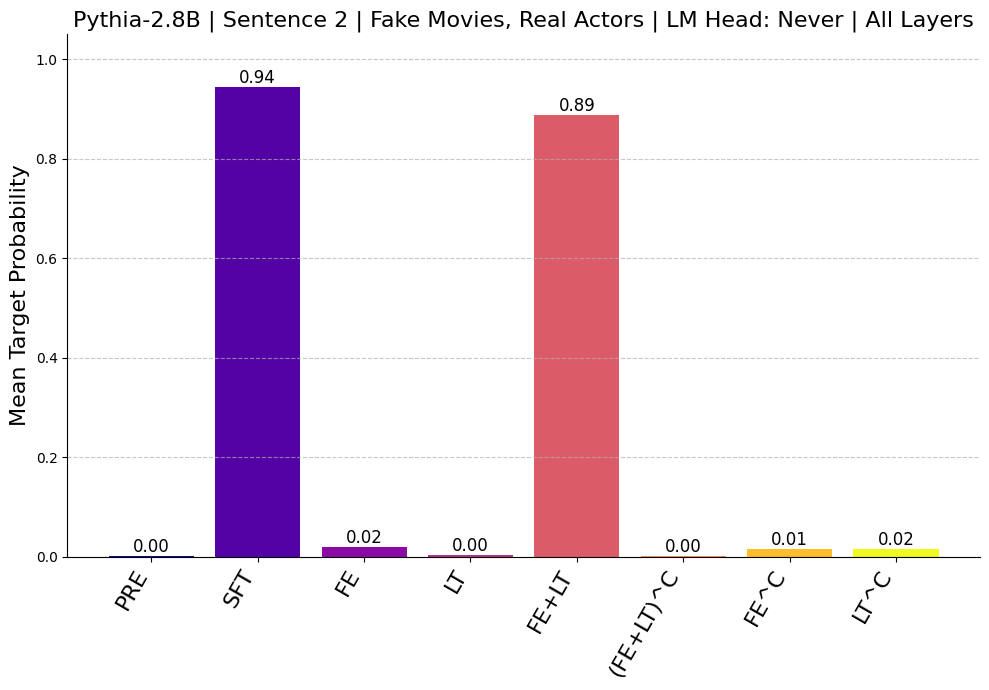

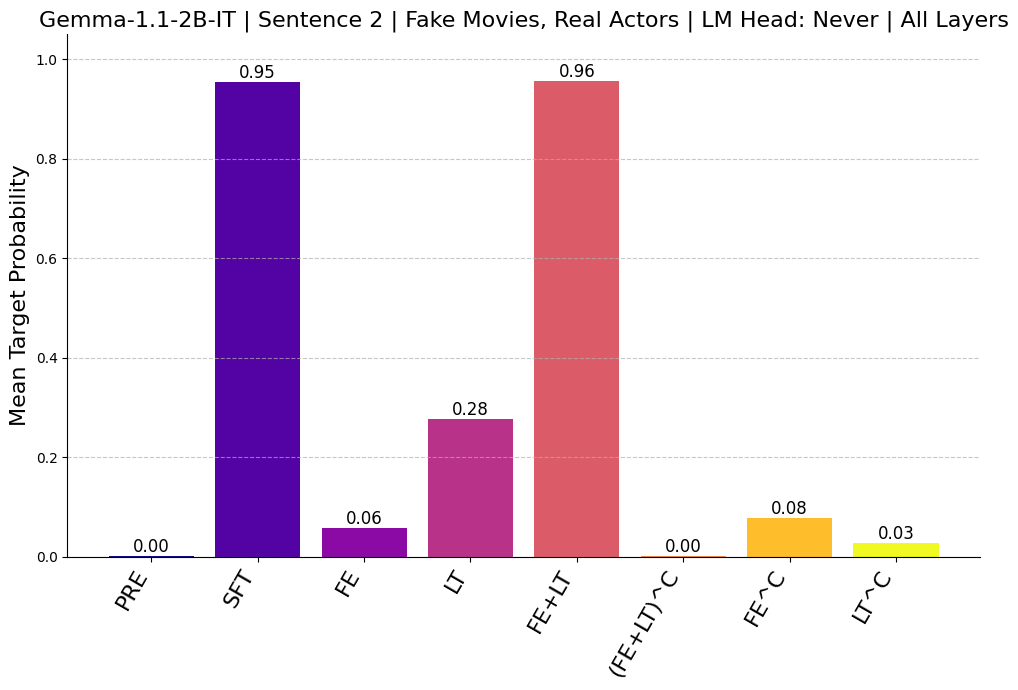

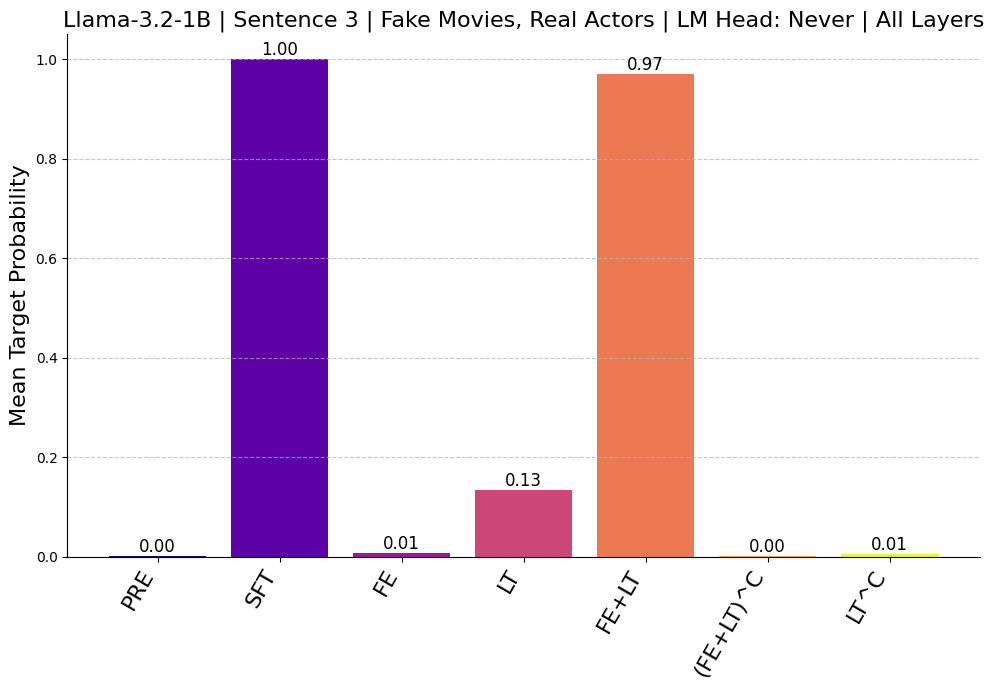

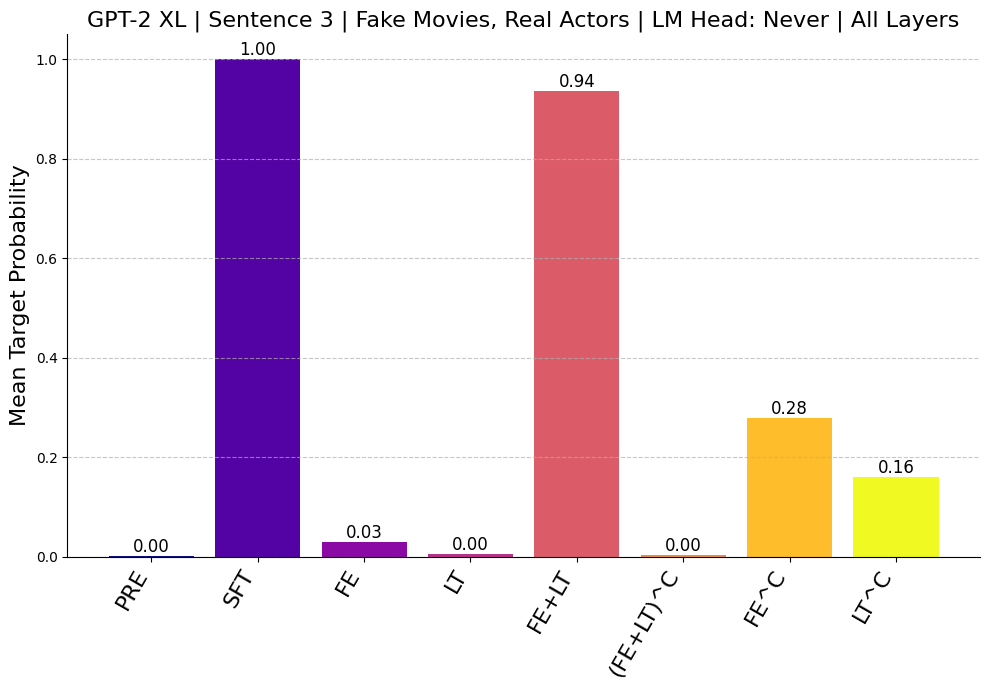

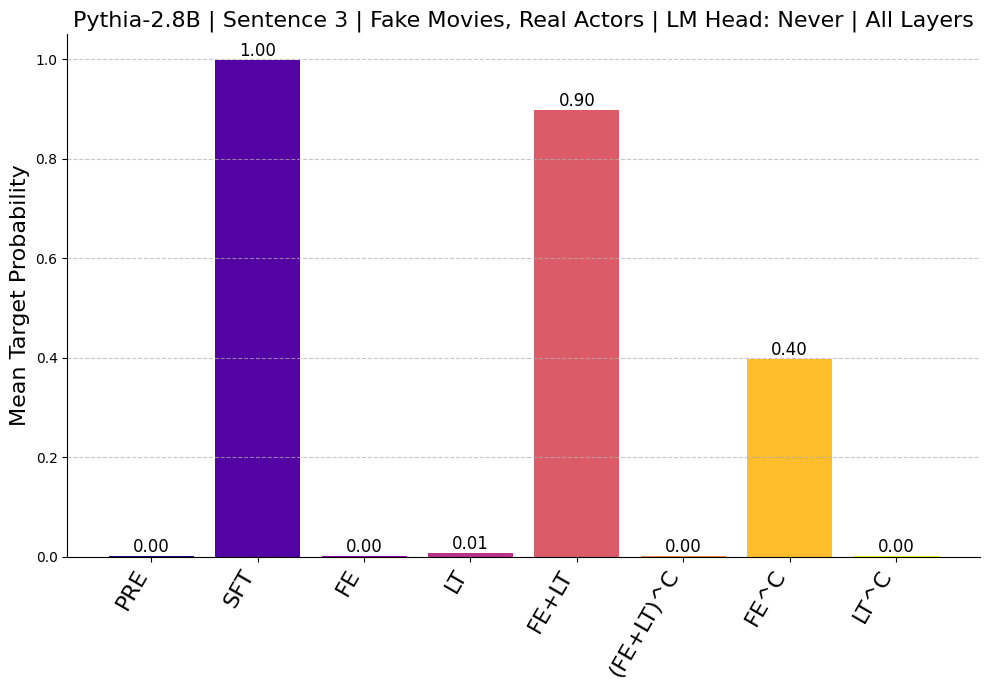

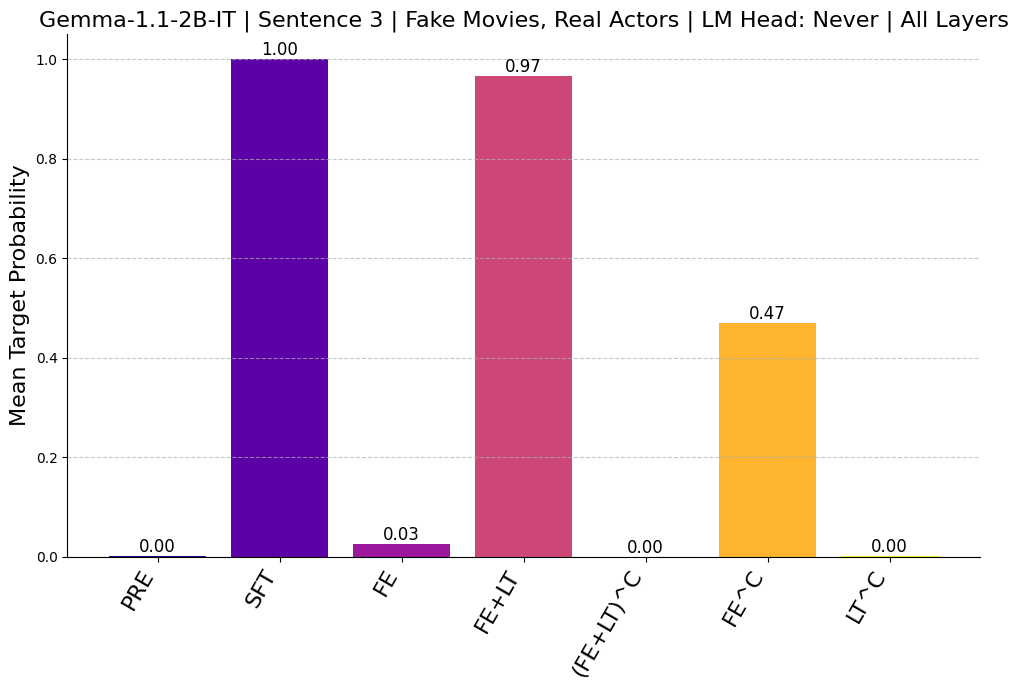

In [30]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key, layers_setting=layers_setting, save=save, core_patches_only=core_patches_only, short_title=short_title)